In [3]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import Image as im
style.use('fivethirtyeight')

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [2]:
stopwords.append('inquirer')
stopwords.append('cookies')
stopwords.append('repo')
stopwords.append('exec')
stopwords.append('dutee')
stopwords.append('said')
stopwords.append('yolanda')

In [3]:
df = pd.read_excel('./Scraped/yolanda-narratives.xlsx')

In [4]:
df.head()

,name,gender,occupation,municipality,province,narrative
0,Ben Evardone,M,congressman,Borongan,Eastern Samar,Eastern Samar is gone. I really don’t know whe...
1,Rosario D. Merilles,F,market vendor,Guiuan,Eastern Samar,"In my market stall, all of our products were d..."
2,Elena G. Gayda,F,market vendor,Lawaan,Eastern Samar,"We knew that it will be a Super Typhoon, but i..."
3,Germi Flynn D. Garfin,M,municipal engineer,Maydolong,Eastern Samar,"Compared to the wind, the rain was not that st..."
4,Enrique A. Cabos,M,mayor,Mercedes,Eastern Samar,We thought we were prepared. We’re used to typ...


In [5]:
len(df)

122

# Cleaning

In [6]:
def clean_text(df):
    df['cleaned_text'] = df['narrative'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|rt|\d+', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'^\s+|\s+$', '') 
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    df['cleaned_split'] = df['cleaned_text'].apply(lambda x: x.split())
    return df

In [7]:
def lemmatize_df(df):
    df['lemmatized'] = df['cleaned_split'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])
    return df

In [8]:
df = clean_text(df)
df = lemmatize_df(df)

In [9]:
df.head()

,name,gender,occupation,municipality,province,narrative,cleaned_text,cleaned_split,lemmatized
0,Ben Evardone,M,congressman,Borongan,Eastern Samar,Eastern Samar is gone. I really don’t know whe...,eastern samar gone really dont know sta cannot...,"[eastern, samar, gone, really, dont, know, sta...","[eastern, samar, gone, really, dont, know, sta..."
1,Rosario D. Merilles,F,market vendor,Guiuan,Eastern Samar,"In my market stall, all of our products were d...",market stall products damaged washed debris ma...,"[market, stall, products, damaged, washed, deb...","[market, stall, product, damaged, washed, debr..."
2,Elena G. Gayda,F,market vendor,Lawaan,Eastern Samar,"We knew that it will be a Super Typhoon, but i...",knew super typhoon strength really took us sur...,"[knew, super, typhoon, strength, really, took,...","[knew, super, typhoon, strength, really, took,..."
3,Germi Flynn D. Garfin,M,municipal engineer,Maydolong,Eastern Samar,"Compared to the wind, the rain was not that st...",compared wind rain strong staed whistle became...,"[compared, wind, rain, strong, staed, whistle,...","[compared, wind, rain, strong, staed, whistle,..."
4,Enrique A. Cabos,M,mayor,Mercedes,Eastern Samar,We thought we were prepared. We’re used to typ...,thought prepared used typhoons know feel surro...,"[thought, prepared, used, typhoons, know, feel...","[thought, prepared, used, typhoon, know, feel,..."


In [10]:
len(df)

122

# Analysis

In [11]:
def tweets_to_dtm(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/dtm.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_ngram(tweets, n=2):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/ngram.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_tfidf(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [12]:
# Get TFIDF matrix
tfidf, tfidf_v = tweets_to_tfidf(df)
print('TFIDF matrix shape:', tfidf.toarray().shape)
list(tfidf_v.vocabulary_.items())[0:5]

TFIDF matrix shape: (122, 2000)


[('eastern', 490),
 ('samar', 1421),
 ('gone', 714),
 ('really', 1317),
 ('dont', 452)]

In [13]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [14]:
freq_tfidf = vector_to_frequency(tfidf, tfidf_v)
freq_tfidf.to_csv('out/frequency_tfidf.csv', index=False)
freq_tfidf.head(20)

,term,frequency
0,market,4.699291
1,typhoon,4.690809
2,damaged,4.296918
3,house,4.140118
4,us,3.757867
5,water,3.552820
6,could,3.525594
7,didnt,3.405715
8,would,3.358030
9,strong,3.276433


Text(0.5, 1.0, 'Frequent terms in TFIDF')

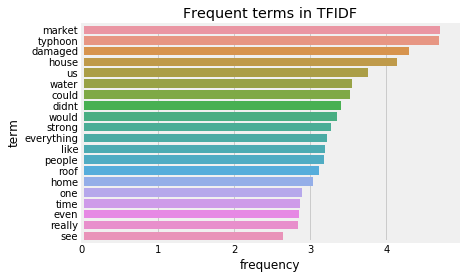

In [15]:
# Visualize frequencies
sns.barplot(data=freq_tfidf.head(20), x='frequency',
            y='term').set_title('Frequent terms in TFIDF')

In [16]:
df['label'] = 'disaster'

In [17]:
df.head()

,name,gender,occupation,municipality,province,narrative,cleaned_text,cleaned_split,lemmatized,label
0,Ben Evardone,M,congressman,Borongan,Eastern Samar,Eastern Samar is gone. I really don’t know whe...,eastern samar gone really dont know sta cannot...,"[eastern, samar, gone, really, dont, know, sta...","[eastern, samar, gone, really, dont, know, sta...",disaster
1,Rosario D. Merilles,F,market vendor,Guiuan,Eastern Samar,"In my market stall, all of our products were d...",market stall products damaged washed debris ma...,"[market, stall, products, damaged, washed, deb...","[market, stall, product, damaged, washed, debr...",disaster
2,Elena G. Gayda,F,market vendor,Lawaan,Eastern Samar,"We knew that it will be a Super Typhoon, but i...",knew super typhoon strength really took us sur...,"[knew, super, typhoon, strength, really, took,...","[knew, super, typhoon, strength, really, took,...",disaster
3,Germi Flynn D. Garfin,M,municipal engineer,Maydolong,Eastern Samar,"Compared to the wind, the rain was not that st...",compared wind rain strong staed whistle became...,"[compared, wind, rain, strong, staed, whistle,...","[compared, wind, rain, strong, staed, whistle,...",disaster
4,Enrique A. Cabos,M,mayor,Mercedes,Eastern Samar,We thought we were prepared. We’re used to typ...,thought prepared used typhoons know feel surro...,"[thought, prepared, used, typhoons, know, feel...","[thought, prepared, used, typhoon, know, feel,...",disaster


In [18]:
df.to_pickle('./Cleaned/disaster_cleaned.pkl')

In [22]:
def clean_text(df):
    df['cleaned_text'] = df['narrative'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(
        r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|rt|\d+', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(
       r'^\s+|\s+$', '')
    df['cleaned_text'] = df['cleaned_text'].apply(
      lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    df['cleaned_split'] = df['cleaned_text'].apply(lambda x: x.split())
    return df

def lemmatize_df(df):
    df['lemmatized'] = df['cleaned_split'].apply(
        lambda x: [lemmatizer.lemmatize(word) for word in x])
    return df

message = "HELLO"
df = pd.DataFrame([message], columns=["narrative"], index=None)

df = clean_text(df)
df = lemmatize_df(df)

In [23]:
df

,narrative,cleaned_text,cleaned_split,lemmatized
0,HELLO,hello,[hello],[hello]


In [16]:
df = pd.DataFrame([text], columns=["narrative"], index=None)

In [21]:
clean_text(df)

,narrative,cleaned_text,cleaned_split
0,HELLO,hello,[hello]
